In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer, AutoModel
from transformers import AutoModelForSequenceClassification, AutoConfig, Trainer, TrainingArguments
import torch

import matplotlib.pyplot as plt
import seaborn as sns

# 1.0 Load Data

In [2]:
df = pd.read_parquet(r"input_data\ccd_labeled_train_validate.parquet")
print(df.shape)
display(df.head())                    

(13268, 6)


date              dlg_id  \
0  2024-10-05  2024-10-07_1017--0   
1  2024-10-05  2024-10-07_1017--1   
2  2024-10-05  2024-10-07_1017--2   
3  2024-10-05  2024-10-07_1017--3   
4  2024-10-05  2024-10-07_1017--4   

                                                text product   action  \
0                      i am still waiting on my card    card  inquire   
1  what can i do if my card still hasnt arrived a...    card  inquire   
2  i have been waiting over a week is the card st...    card  inquire   
3  can i track my card while it is in the process...    card  inquire   
4  how do i know if i will get my card or if it i...    card  inquire   

  sentiment  
0  negative  
1  negative  
2  negative  
3   neutral  
4   neutral

In [3]:
# # testing - check for duplicates or errors in labels
# sorted(df['product'].unique())

# 2.0 EDA

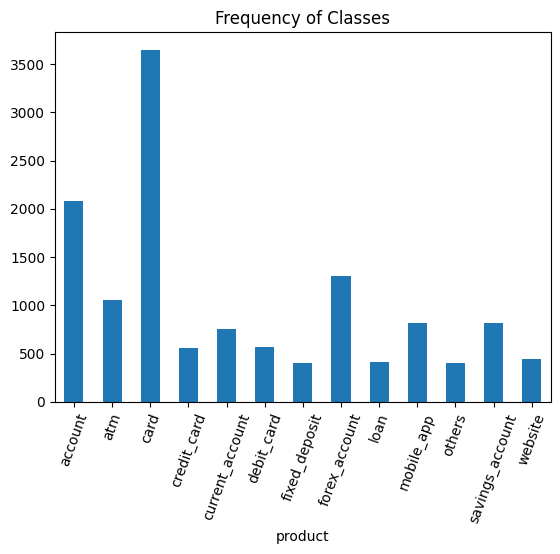

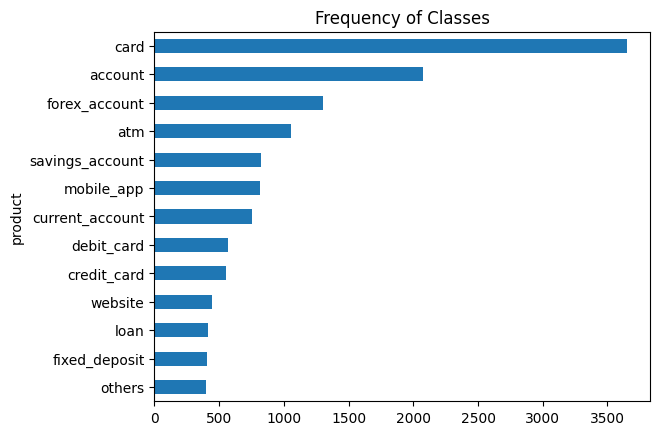

In [4]:
# testing - check for duplicates or errors in labels
plt.title("Frequency of Classes")
df['product'].value_counts().sort_index().plot(kind='bar', rot=70)
plt.show()

plt.title("Frequency of Classes")
df['product'].value_counts(ascending=True).plot.barh()
plt.show()

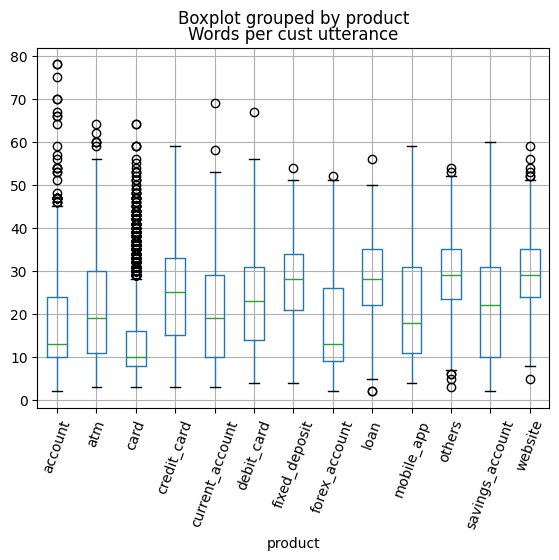

In [5]:
aa = pd.DataFrame()
aa['Words per cust utterance'] = df['text'].str.split().apply(len)
aa['product'] = df['product'].copy()
aa.boxplot("Words per cust utterance", by="product", rot=70)
plt.show()

# 3.0 Data Prep

### 3.1 Remove columns that are not required for training this model
We only want:
- 'text' aka Feature X
- 'product' aka Target y

In [6]:
dft = df[['text', 'product']].copy()
dft.rename(columns={'product': 'label_name'}, inplace=True)
display(dft.head(3))
print()

text label_name
0                      i am still waiting on my card       card
1  what can i do if my card still hasnt arrived a...       card
2  i have been waiting over a week is the card st...       card

### 3.2 Define `label2id` and `id2label`

In [7]:
label_name = sorted(dft['label_name'].unique())
label = [i for i in range(len(label_name))]

label2id = {lbl_name: lbl for lbl_name, lbl in zip(label_name, label)}
id2label = {lbl: lbl_name for lbl_name, lbl in zip(label_name, label)}
for k, v in label2id.items():
    print(f"{str(k):15}", ' --- ', v)
# for k, v in id2label.items():
#     print(f"{str(k):15}", ' --- ', v)

account          ---  0
atm              ---  1
card             ---  2
credit_card      ---  3
current_account  ---  4
debit_card       ---  5
fixed_deposit    ---  6
forex_account    ---  7
loan             ---  8
mobile_app       ---  9
others           ---  10
savings_account  ---  11
website          ---  12


### 3.3 Create column to Hold Label as Integer

In [8]:
dft['label'] =dft['label_name'].apply(lambda x: label2id[x])
dft = dft[['text', 'label', 'label_name']]
dft.sample(5)

text  label     label_name
4276        am i able to order a disposable virtual card      2           card
3429   i would like to make a purchase however my car...      2           card
10403  That’s all for now. I’ll be waiting for your c...      6  fixed_deposit
1039                       my card has been lost  stolen      2           card
13041  I haven't had any problems with other websites...     12        website

### 3.4 Create `train`, `validation`, and `test` datasets

In [9]:
train, test = train_test_split(dft, test_size=0.3, stratify=dft['label_name'], random_state=42)
test, validation = train_test_split(test, test_size=1/3, stratify=test['label_name'], random_state=42)

train.shape, validation.shape, test.shape

((9287, 3), (1327, 3), (2654, 3))

### 3.5 Convert to HF Dataset

In [10]:
dataset = DatasetDict(
    {'train':Dataset.from_pandas(train, preserve_index=False),
     'test':Dataset.from_pandas(test, preserve_index=False),
     'validation': Dataset.from_pandas(validation, preserve_index=False)
     }
)
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'label_name'],
        num_rows: 9287
    })
    test: Dataset({
        features: ['text', 'label', 'label_name'],
        num_rows: 2654
    })
    validation: Dataset({
        features: ['text', 'label', 'label_name'],
        num_rows: 1327
    })
})

In [11]:
# # model_ckpt = "distilbert-base-uncased"
# model_ckpt = "bert-base-uncased"
# tokenizer = AutoTokenizer.from_pretrained(model_ckpt)


# text = "I love machine learning! Tokenization is awesome!!"
# encoded_text = tokenizer(text)
# print(encoded_text)

In [12]:
# len(tokenizer.vocab), tokenizer.vocab_size, tokenizer.model_max_length

# 4.0 Tokenise Data

### 4.1 Load Tokenizers
- distilbert-base-uncased
- google/mobilebert-uncased
- huawei-noah/TinyBERT_General_4L_312D

In [13]:
# from transformers import AutoTokenizer

# model_ckpt = "distilbert-base-uncased"
# distilbert_tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
# print(distilbert_tokenizer, '\n')

# model_ckpt = "google/mobilebert-uncased"
# mobilebert_tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
# print(mobilebert_tokenizer, '\n')

# model_ckpt = "huawei-noah/TinyBERT_General_4L_312D"
# tinybert_tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
# print(tinybert_tokenizer, '\n')

### 4.2 Tokenize Functions

In [14]:
# def tokenize(tokenizer_model, batch, col_name: str):
#     """
#     returns the tokenised batch
#     """
#     return tokenizer_model(batch[col_name], padding=True, truncation=True)

# print(tokenize(
#     tokenizer_model = distilbert_tokenizer, 
#     batch=dataset['train'][:2], 
#     col_name='text')
# )

In [15]:
# def batch_tokenize_distilbert(batch):
#     return distilbert_tokenizer(batch['text'], padding=True, truncation=True)
#     return temp

# print(batch_tokenize_distilbert(dataset['train'][:2]))

In [16]:
# testing the function
# encoded_dataset = dataset.map(batch_tokenize_distilbert, batch_size=None, batched=True)

In [17]:
# del encoded_dataset

# 5.0 Build Multiple Models

In [18]:
# use sklearn to build compute metrics
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)

    return {"accuracy": acc, "f1": f1}

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
feature_col_name = 'text'

model_dict = {
    "bert-base": "bert-base-uncased",
    "distilbert": "distilbert-base-uncased",
    "mobilebert": "google/mobilebert-uncased",
    "tinybert": "huawei-noah/TinyBERT_General_4L_312D"
}

def train_model(model_name):
    model_ckpt = model_dict[model_name]
    tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
    config = AutoConfig.from_pretrained(model_ckpt, label2id=label2id, id2label=id2label)
    model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, config=config).to(device)

    def local_tokenizer(batch):
        return tokenizer(batch[feature_col_name], padding=True, truncation=True)
    
    encoded_dataset = dataset.map(local_tokenizer, batched=True, batch_size=None)

    trainer = Trainer(
                model=model,
                compute_metrics=compute_metrics,
                train_dataset=encoded_dataset['train'],
                eval_dataset=encoded_dataset['validation'],
                tokenizer=tokenizer
            )
    
    trainer.train()

    preds = trainer.predict(encoded_dataset['test'])

    return preds.metrics
    

import time
model_performance = {}
for model_name in model_dict:
    print("\n\n")
    print("Training Model: ", model_name)

    start = time.time()
    result = train_model(model_name)
    end = time.time()
    
    model_performance[model_name] = {model_name:result, "time taken": end-start}

In [ ]:
model_performance

In [ ]:
print(dataset['train'][0], '\n\n') 
print(dataset['train'][1])

In [ ]:
def tokenize(batch):
    temp = tokenizer(batch['text'], padding=True, truncation=True)
    return temp

print(tokenize(dataset['train'][:2]))

In [ ]:
ccd_encoded = dataset.map(tokenize, batched=True, batch_size=None)
ccd_encoded

# Build Model

In [ ]:
# model = AutoModel.from_pretrained(model_ckpt)
# print(model)
# print(model.config.id2label)
# print(model.config)

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoConfig

num_labels = len(label2id)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
config = AutoConfig.from_pretrained(model_ckpt, label2id=label2id, id2label=id2label)
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, config=config).to(device)
device

In [ ]:
# print(model.config.id2label)

In [ ]:
# print(model)
print(model.config)

In [ ]:
from transformers import TrainingArguments

batch_size = 64
training_dir = "trained_model/bert_base_train_dir"

training_args = TrainingArguments( output_dir=training_dir,
                                  overwrite_output_dir = True,
                                  num_train_epochs = 1,  # change num epochs
                                  learning_rate = 2e-5,
                                  per_device_train_batch_size = batch_size,
                                  per_device_eval_batch_size = batch_size,
                                  weight_decay = 0.01,
                                  evaluation_strategy = 'epoch',
                                  disable_tqdm = False
                                 )

In [ ]:
# use sklearn to build compute metrics
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)

    return {"accuracy": acc, "f1": f1}

In [ ]:
trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset = ccd_encoded['train'],
                  eval_dataset = ccd_encoded['validation'],
                  tokenizer = tokenizer)

In [ ]:
trainer.train()

# Model Evaluation

In [ ]:
preds_output = trainer.predict(ccd['test'])
preds_output.metrics

In [ ]:
y_pred = np.argmax(preds_output.predictions, axis=1)
y_true = ccd_encoded['test'][:]['label']

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

In [ ]:
label2id

In [ ]:
# plot confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, xticklabels=label2id.keys(), yticklabels=label2id.keys(), fmt='d', cbar=False, cmap='Reds')
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

# Build Prediction Function and Store Model

In [ ]:
text = "I want to open a fixed deposit account now, thank you."

def get_prediction(text):
    input_encoded = tokenizer(text, return_tensors='pt').to(device)

    with torch.no_grad():
        outputs = model(**input_encoded)

    logits = outputs.logits

    pred = torch.argmax(logits, dim=1).item()
    return id2label[pred]

get_prediction(text)

In [ ]:
trainer.save_model("model_trained/bert-base-uncased-product_clr-model")

In [ ]:
# use pipeline for prediciton
from transformers import pipeline

classifier = pipeline('text-classification', model= 'model_trained/bert-base-uncased-sentiment-model')

classifier(["I want to open a fixed deposit account now, thank you.", "your atm swallowed my card", "Why is your loan interest rate so high?"])